In [55]:
import os
import numpy as np
import torch
import glob
import torch.nn as nn
from torchvision.transforms import transforms
from torch.utils.data import DataLoader, Subset
from torch.optim import Adam
from torch.autograd import Variable
import torchvision
import pathlib
from torchvision.models import squeezenet1_1
import torch.functional as F
import cv2
import matplotlib.pyplot as plt

In [56]:
device = torch.device('cpu')

In [57]:
#Transforms
transformer = transforms.Compose([
    transforms.Resize((150,150)),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),  # конверт глубины (0, 255) до (0,1)
    transforms.Normalize([0.5,0.5,0.5], # (0, 1) до (-1,1) - (средняя по x)/std
                        [0.5,0.5,0.5])
])

In [58]:
train_path = 'seg_train/seg_train'
test_path = 'seg_test/seg_test'
train_loader = DataLoader(
    torchvision.datasets.ImageFolder(train_path,transform = transformer),
    batch_size = 64, shuffle = True
)
test_loader = DataLoader(
    torchvision.datasets.ImageFolder(test_path,transform =transformer),
    batch_size = 32, shuffle = True
)

In [59]:
root = pathlib.Path(train_path)
classes = sorted([j.name.split('/')[-1] for j in root.iterdir()])

In [60]:
class ConvNet(nn.Module):
    def __init__(self, num_classes=6):
        super(ConvNet,self).__init__()
        self.conv1 = nn.Conv2d(in_channels=3,out_channels=12,kernel_size=3,stride=1,padding=1)
        self.bn1 = nn.BatchNorm2d(num_features=12)
        self.relu1 = nn.ReLU()
        self.pool = nn.MaxPool2d(kernel_size=2)       
        self.conv2 = nn.Conv2d(in_channels=12,out_channels=20,kernel_size=3,stride=1,padding=1)
        self.relu2 = nn.ReLU()      
        self.conv3 = nn.Conv2d(in_channels=20,out_channels=32,kernel_size=3,stride=1,padding=1)
        self.bn3 = nn.BatchNorm2d(num_features=32)
        self.relu3 = nn.ReLU()
        self.fc = nn.Linear(in_features=75 * 75 * 32,out_features=num_classes)
        
    def forward(self,input):
        output = self.conv1(input)
        output = self.bn1(output)
        output = self.relu1(output)           
        output = self.pool(output)
        output = self.conv2(output)
        output = self.relu2(output)
        output = self.conv3(output)
        output = self.bn3(output)
        output = self.relu3(output)
        output = output.view(-1,32*75*75)
        return self.fc(output)
            
        

In [61]:
model = ConvNet().to(device)

In [62]:
optimizer = Adam(model.parameters(),lr = 0.001, weight_decay = 0.0001)
loss_function = nn.CrossEntropyLoss()

In [63]:
train_count = len(glob.glob(train_path + '/**/*.jpg'))
test_count = len(glob.glob(test_path + '/**/*.jpg'))

In [70]:
best_accuracy = 0.0
for epoch in range(3):
    model.train()
    
    train_accuracy = 0.0
    train_loss = 0.0
    
    for i, (images,labels) in enumerate(train_loader):
        optimizer.zero_grad()
        outputs=model(images)
        loss=loss_function(outputs,labels)
        loss.backward()
        optimizer.step()
        train_loss += loss.cpu().data*images.size(0)
        _, prediction = torch.max(outputs.data,1)
        
        train_accuracy += int(torch.sum(prediction == labels.data))
        
    train_accuracy = train_accuracy/train_count
    train_loss = train_loss/train_count
    model.eval()
    
    test_accuracy = 0.0
    
    for i, (images,labels) in enumerate(test_loader):
        outputs=model(images)
        _, prediction = torch.max(outputs.data,1)
        test_accuracy += int(torch.sum(prediction == labels.data))
    test_accuracy = test_accuracy / test_count
    
    
    print(f"""Эпоха: {epoch + 1} 
              Потери: {train_loss} 
              Трейн Accuracy: {train_accuracy} 
              Тест Accuracy: {test_accuracy}\n""")
    
    # Лучший результат
    if test_accuracy > best_accuracy:
        best_model = model
        best_accuracy = test_accuracy

Эпоха: 1 
              Потери: 0.3993716239929199 
              Трейн Accuracy: 0.8765141798489383 
              Тест Accuracy: 0.7353333333333333

Эпоха: 2 
              Потери: 0.2764551639556885 
              Трейн Accuracy: 0.9123557075673364 
              Тест Accuracy: 0.747

Эпоха: 3 
              Потери: 0.21481972932815552 
              Трейн Accuracy: 0.9334473421690181 
              Тест Accuracy: 0.7563333333333333



In [72]:
best_model.eval()

ConvNet(
  (conv1): Conv2d(3, 12, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn1): BatchNorm2d(12, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu1): ReLU()
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(12, 20, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (relu2): ReLU()
  (conv3): Conv2d(20, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn3): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu3): ReLU()
  (fc): Linear(in_features=180000, out_features=6, bias=True)
)

In [74]:
def prediction(img_path, transformer):
    image = Image.open(img_path)
    image_tensor = transformer(image).float()
    image_tensor = image_tensor.unsqueeze_(0)
    input_ = Variable(image_tensor)
    output = model(input_)
    index = output.data.numpy().argmax()
    pred = classes[index]
    return pred

def imshow(inp):
    channel_means = (0.485, 0.456, 0.406)
    channel_stds = (0.229, 0.224, 0.225)
    
    inp = inp.numpy().transpose((1, 2, 0))
    inp = channel_stds * inp + channel_means
    inp = np.clip(inp, 0, 1)
    fig = plt.figure(figsize = None)
    ax = fig.add_subplot(111)
    ax.imshow(inp)
    ax.set_aspect('equal')
    plt.pause(0.001)  

forest


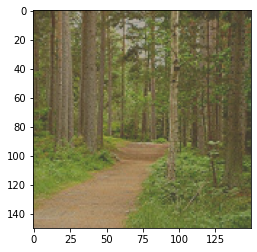

In [75]:
pred_dataset = torchvision.datasets.ImageFolder('seg_pred', transform = transformer)
print(prediction('seg_pred/seg_pred/24331.jpg', transformer)) # предпоследняя картинка в папке
imshow(pred_dataset[-2][0]) # предпоследняя картинка в датасете